In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Finance related operations
import pandas_datareader

# Import this to silence a warning when converting data column of a dataframe on the fly
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

## 1. Load Data

We are loading the every csv file separately from the Data folder in the project directory. Once we have stored them in our Notebook we merge them together to form a larger dataframe containing all the information we have available.

In [2]:
df_2014 = pd.read_csv('Data/2014_Financial_Data.csv', index_col=0)
df_2015 = pd.read_csv('Data/2015_Financial_Data.csv', index_col=0)
df_2016 = pd.read_csv('Data/2016_Financial_Data.csv', index_col=0)
df_2017 = pd.read_csv('Data/2017_Financial_Data.csv', index_col=0)
df_2018 = pd.read_csv('Data/2018_Financial_Data.csv', index_col=0)

Now we add new YEAR column to each of the dataframes to later being able to group the rows by their year. We add them to an array, so we can iterate over them.

In [3]:
df_2014['year'] = '2014'
df_2015['year'] = '2015'
df_2016['year'] = '2016'
df_2017['year'] = '2017'
df_2018['year'] = '2018'

dataframes = [df_2014, df_2015, df_2016, df_2017, df_2018]

# 2. Merging of datasets

In [4]:
for df in dataframes:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3808 entries, PG to WTT
Columns: 225 entries, Revenue to year
dtypes: float64(222), int64(1), object(2)
memory usage: 6.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4120 entries, PG to WTT
Columns: 225 entries, Revenue to year
dtypes: float64(222), int64(1), object(2)
memory usage: 7.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4797 entries, PG to WTT
Columns: 225 entries, Revenue to year
dtypes: float64(222), int64(1), object(2)
memory usage: 8.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4960 entries, PG to WTT
Columns: 225 entries, Revenue to year
dtypes: float64(222), int64(1), object(2)
memory usage: 8.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4392 entries, CMCSA to ZYME
Columns: 225 entries, Revenue to year
dtypes: float64(222), int64(1), object(2)
memory usage: 7.6+ MB
None


We can see that the datasets are quite similar. The only thing that varies between them is the number of rows. As we want to append all the datasets to form a bigger dataset we expect 3808 + 4120 + 4797 + 4960 + 4392 = 22'077 rows in the generated dataset.

Looking at the column data types we have:
- 222 numeric (financial indicators)
- 1 integer (the **class** column)
- 2 objects (**Sector and Price Change** column)

In order to be able to append all the dataframes together we have to make sure all the columns have the same naming. It looks like the only column that is named differently from all the others across the datasets is the price change column. We are renaming it to 'PRICE CHANGE [%]'.


In [5]:
year = 2015
for df in dataframes:
    df.rename(columns = {f'{year} PRICE VAR [%]': 'PRICE CHANGE [%]'}, inplace=True)
    year += 1

To check our assumption and see if now all the columns really are the same we use the numpy array_equal function.

In [6]:
columns_2014 = df_2014.columns.values.tolist()
columns_2015 = df_2015.columns.values.tolist()
columns_2016 = df_2016.columns.values.tolist()
columns_2017 = df_2017.columns.values.tolist()
columns_2018 = df_2018.columns.values.tolist()

print(f'Columns in df 2014 and 2015 are equal: {np.array_equal(columns_2014, columns_2015)}')
print(f'Columns in df 2015 and 2016 are equal: {np.array_equal(columns_2015, columns_2016)}')
print(f'Columns in df 2016 and 2017 are equal: {np.array_equal(columns_2016, columns_2017)}')
print(f'Columns in df 2017 and 2018 are equal: {np.array_equal(columns_2017, columns_2018)}')

Columns in df 2014 and 2015 are equal: True
Columns in df 2015 and 2016 are equal: True
Columns in df 2016 and 2017 are equal: True
Columns in df 2017 and 2018 are equal: True


As we see that all computations output TRUE. By reflexivity we know that the columns of all the datasets now have the same values. Now we can start appending them to form the mega-dataset we want to start working with.

In [15]:
df = pd.concat(dataframes)

As expected we get a new dataframe with 22'077 entries and the common number of columns (225) of the individual datasets.

# 3. Start cleaning
Now that we have some information at one place we can start cleaning the dataset.

## 3.1 Price Change outliers
As Price change is probably our most important feature we want to prepare that one first. This section is strongly inspired by an analysis done by Nicolas Carbone and can be found [HERE](https://www.kaggle.com/cnic92/explore-and-clean-financial-indicators-dataset)
We are looking for major peaks/valleys, which indicate stocks that increased/decreased in value by an incredible amount with respect to the overall sector.

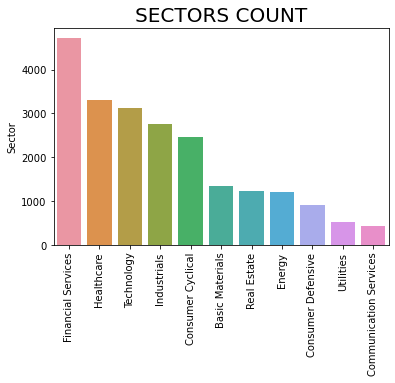

In [16]:
sectors = df['Sector'].unique().tolist()

df_sector = df['Sector'].value_counts()
sns.barplot(x=np.arange(len(df_sector)), y=df_sector)
plt.xticks(np.arange(len(df_sector)), df_sector.index.values.tolist(), rotation=90)
plt.title('SECTORS COUNT', fontsize=20)
plt.show()

As we see our dataset is unbalanced in regards to the sector count. This can lead to overfitting, but we will leave the data as is as it represents the true distribution of sectors in reality. Now let's take a look at a graphical representation of all the returns within a sector in the year 2019.

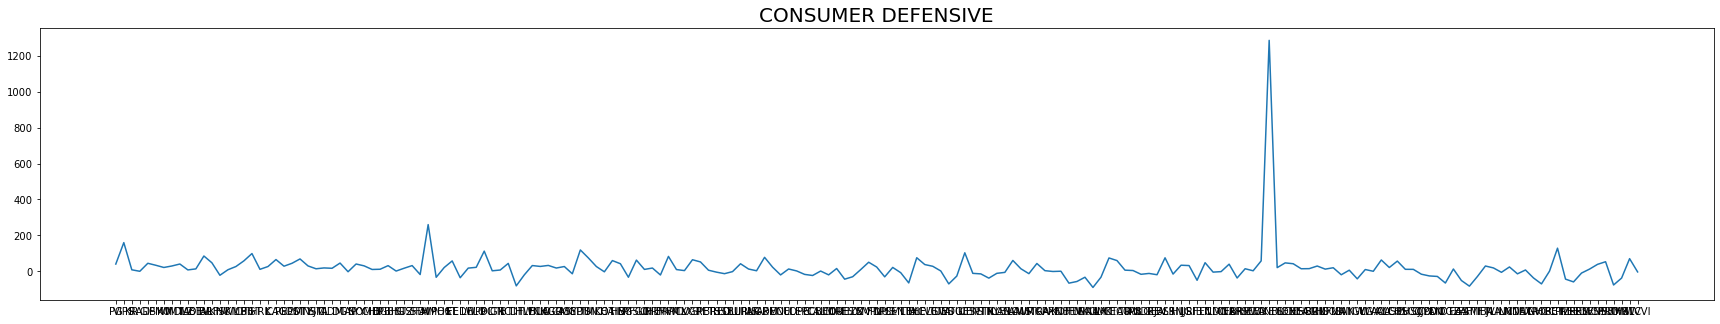

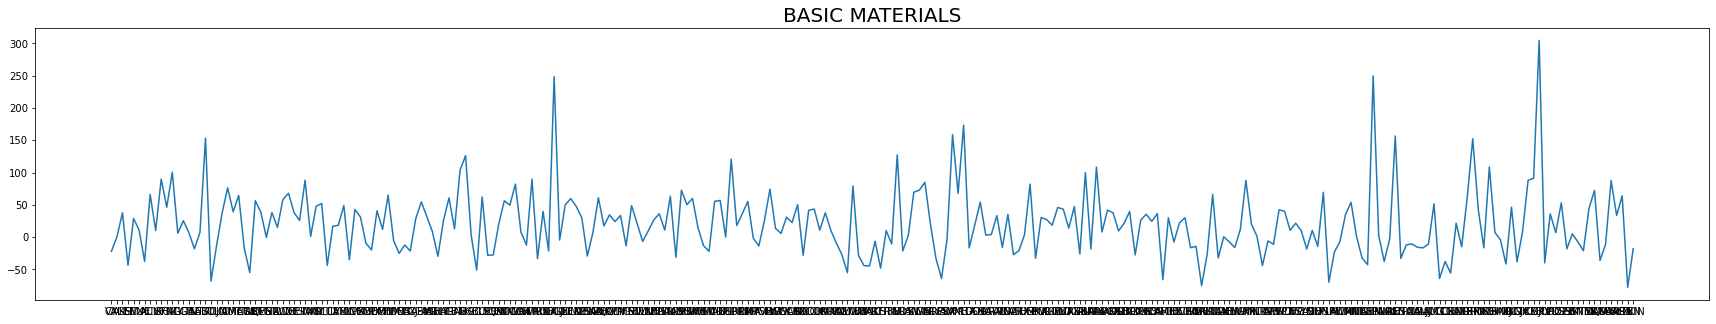

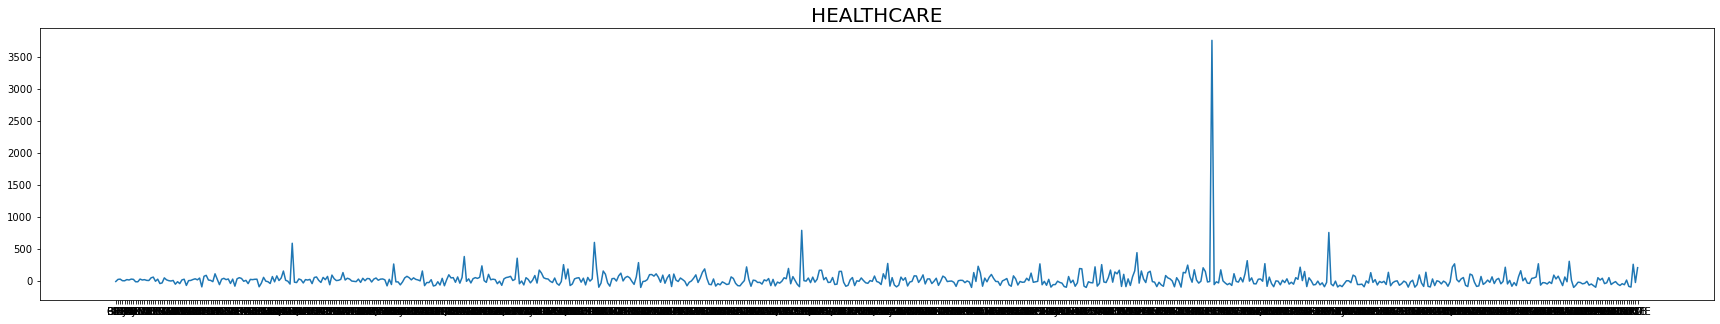

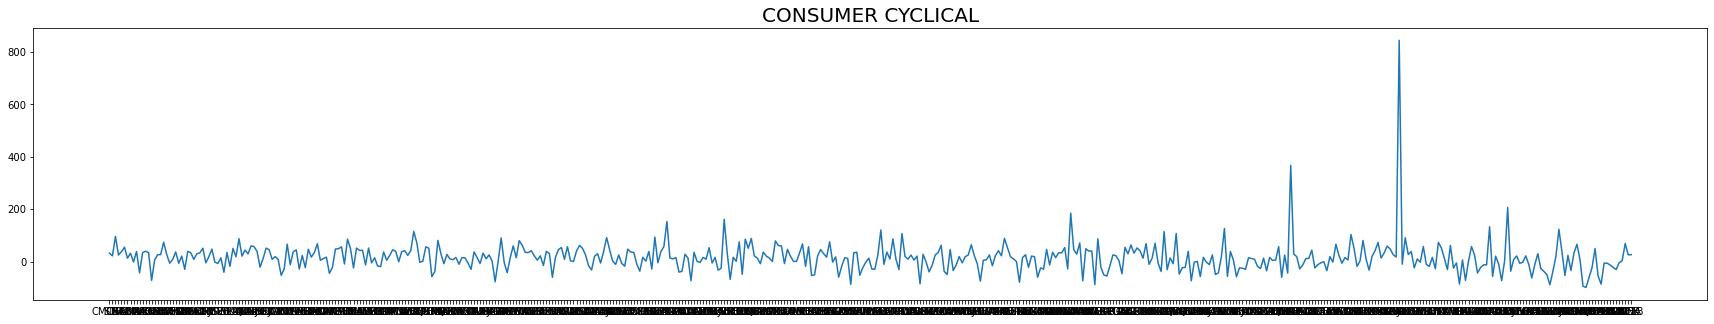

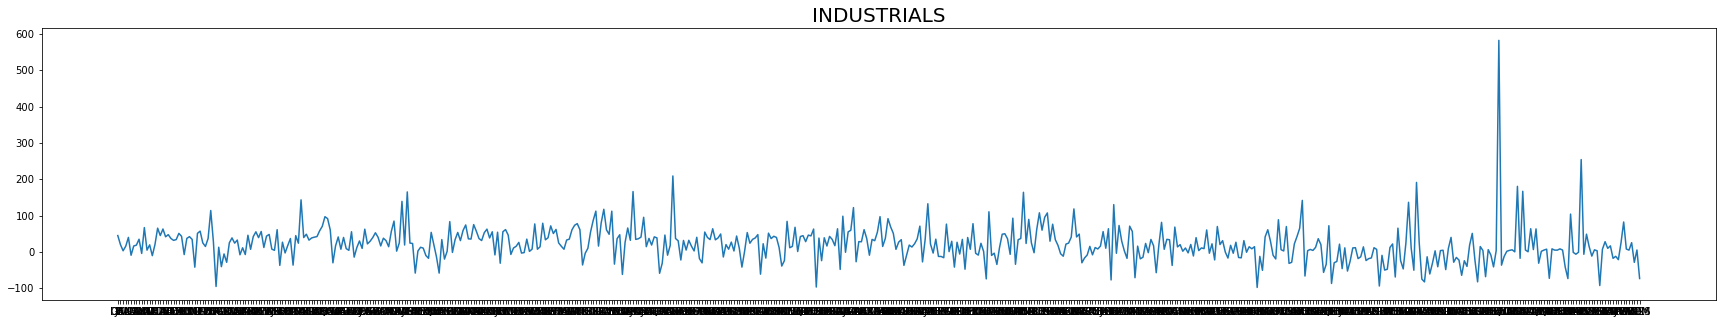

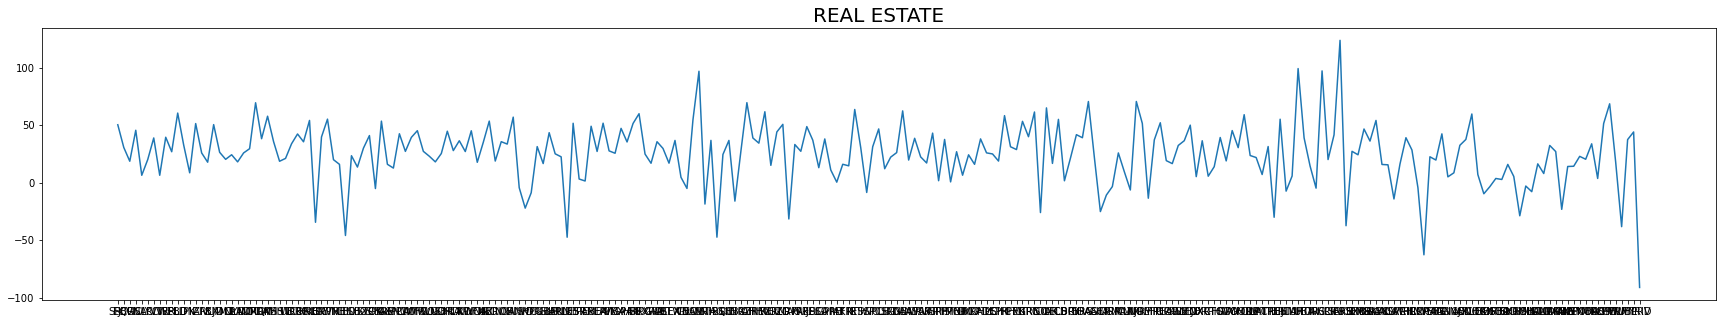

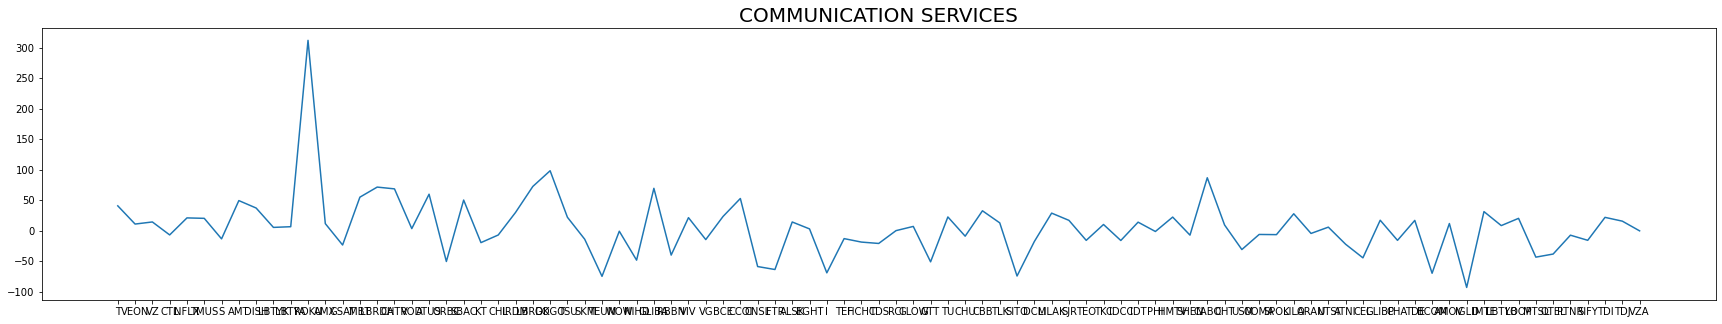

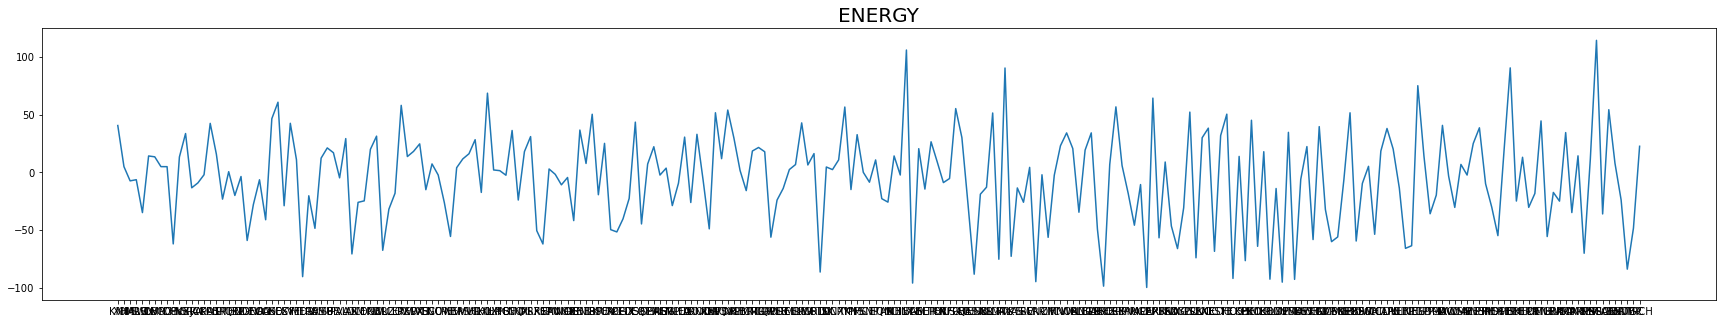

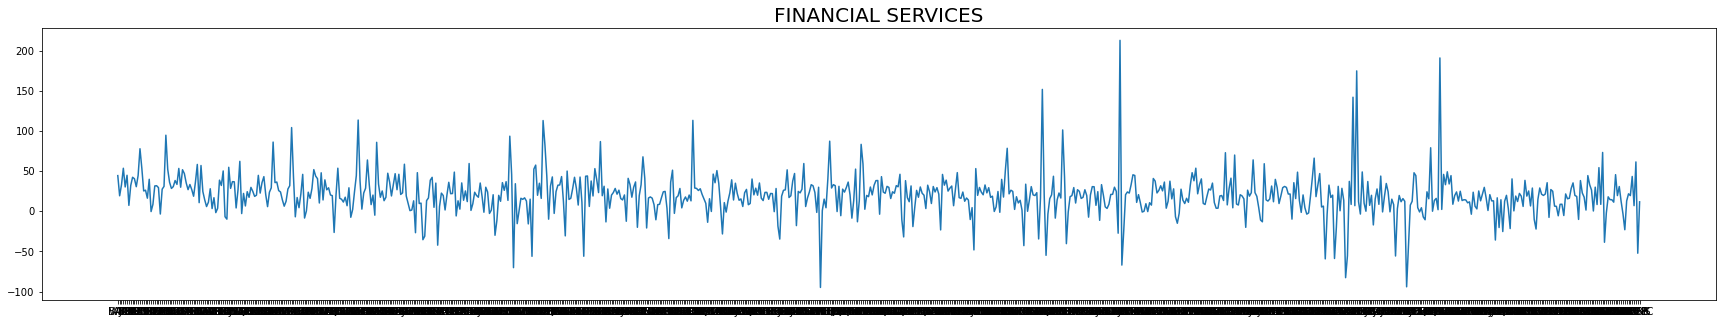

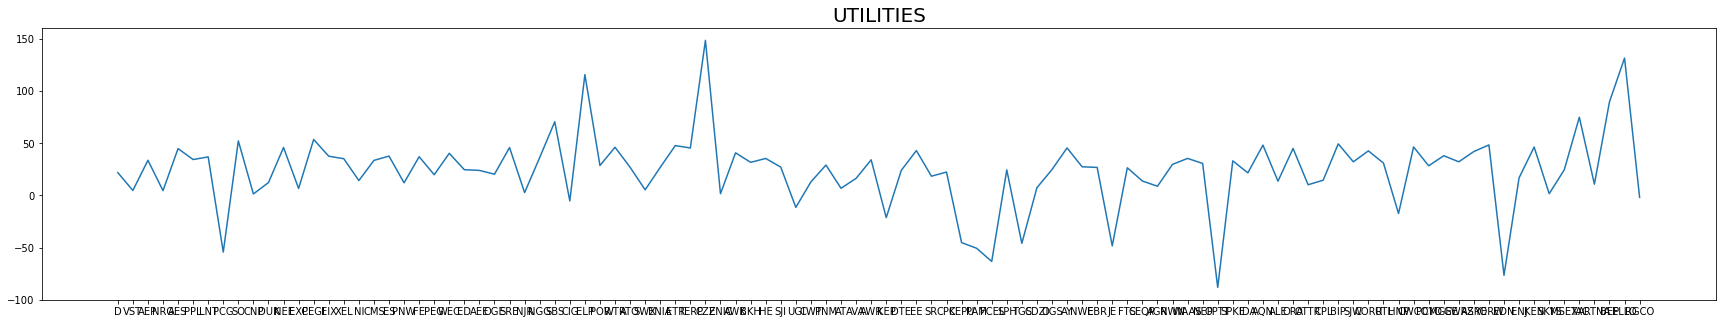

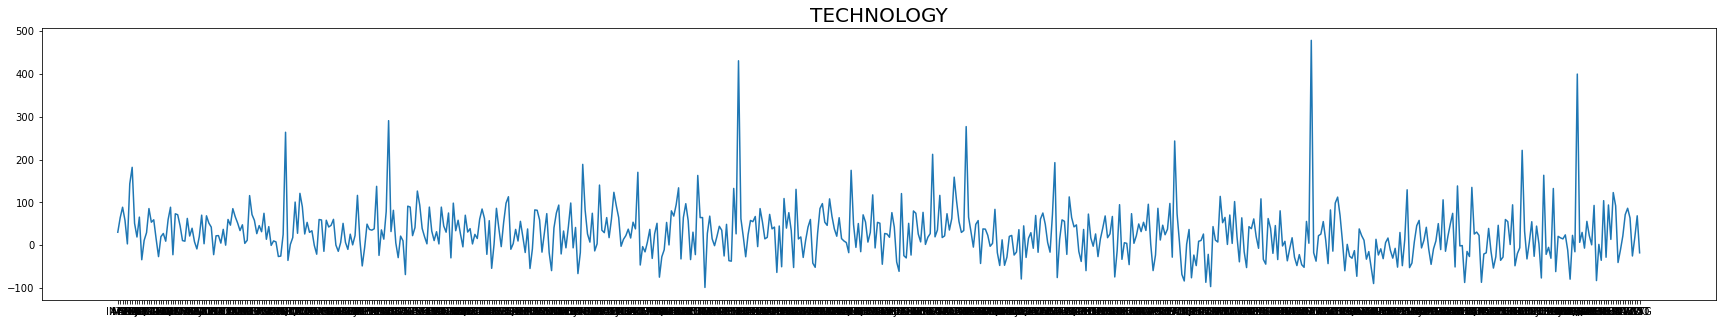

In [18]:
# Extract the columns we need in this step from the dataframe
df_ = df_2018.loc[:, ['Sector', 'PRICE CHANGE [%]']]

# Get list of sectors
sector_list = df_['Sector'].unique()

# Plot the percent price variation for each sector
for sector in sectors:

    temp = df_[df_['Sector'] == sector]

    plt.figure(figsize=(30,5))
    plt.plot(temp['PRICE CHANGE [%]'])
    plt.title(sector.upper(), fontsize=20)
    plt.show()

As we see there is quite a number of peaks. We now want to dig a little deeper into that and examine wether those price changes could have been organic or inorganic growth. [Nicolas Carbone](https://www.kaggle.com/cnic92/explore-and-clean-financial-indicators-dataset) suggests to determine a threshhold, find all stocks that have performed better than the threshhold and get some financial data from Yahoo Finance for these specific stocks. More precisely we will compare the *Adjusted Daily Close Price* to the *Volume* and decide on that basis if it was organic or inorganic growth. We will do exactly that for every stock that had a performance greater that 500% in any year of our dataset.

### 3.1.1 Price Changes >500% in 2014